In [1]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search for parameters tuning
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams # para graficar las variables más importantes para el modelo
from sklearn.cross_validation import train_test_split # para separar los data sets.

In [2]:
#importar datos 
#link Data: https://www.kaggle.com/zhengjiaqin/analyse-hr-comma-sep-data/data
file= 'HR_comma_sep.csv'
datos=pd.read_csv(file,
                       header=0,
                       sep=',',
                       parse_dates=False,
                       skip_blank_lines=True)
datos.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
#tratar variables cualitativas
 # variable "salary"
datos['salary']=datos.salary.map({'low':1,'medium':2,'high':3})
 #variable "sales=area"
rh=datos.iloc[:,0:8]
temp=pd.get_dummies(datos['sales'])
temp1=datos.iloc[:,9:10]
datos=rh.join(temp).join(temp1)    
datos

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,salary
0,0.38,0.53,2,157,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.80,0.86,5,262,6,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
2,0.11,0.88,7,272,4,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
3,0.72,0.87,5,223,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0.37,0.52,2,159,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5,0.41,0.50,2,153,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
6,0.10,0.77,6,247,4,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
7,0.92,0.85,5,259,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
8,0.89,1.00,5,224,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
9,0.42,0.53,2,142,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [4]:
%matplotlib inline

In [5]:
# define a function which will help us create GBM models and perform cross-validation.

def modelfit1(algorithm,datos, performCV=True, printFeatureImportance=True):
    
    #separar "x,y"
    Y=datos.iloc[:,6:7]
    X=datos.ix[:, datos.columns != 'left']
    
    #separar datos de entrenamiento y prueba
    X_train,X_other,Y_train,Y_other = train_test_split(X,Y, test_size=0.6, random_state=0)
    X_cross,X_test,Y_cross,Y_test = train_test_split(X_other,Y_other, test_size=0.5, random_state=5)
    #Y_train=np.array(Y_train)
            
    #Fit the algorithm on the training data
    algorithm.fit(X_train,Y_train)
        
    #Predict training set:
    dtrain_predictions = algorithm.predict(X_train)
    dtrain_predprob = algorithm.predict_proba(X_train)[:,1]
     
    #Perform cross-validation:
    if performCV:
                
        #Predict cross validation set:
        dcross_predictions = algorithm.predict(X_cross)
        dcross_predprob = algorithm.predict_proba(X_cross)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Training Recall : %.4g" % metrics.recall_score(Y_train.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(Y_train, dtrain_predprob))
      
    if performCV:
        print ("CV Recall : %.4g" % metrics.recall_score(Y_cross.values, dcross_predictions))
        print ("AUC Score (CV): %f" % metrics.roc_auc_score(Y_cross, dcross_predprob))
        
        
    #Print Feature Importance:
    if printFeatureImportance:
        predictors=list(X_train.columns.values)
        feat_imp = pd.Series(algorithm.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    return X_train,Y_train
        

C:\Users\Edu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Training Recall : 0.9268
AUC Score (Train): 0.989732
CV Recall : 0.9336
AUC Score (CV): 0.989012


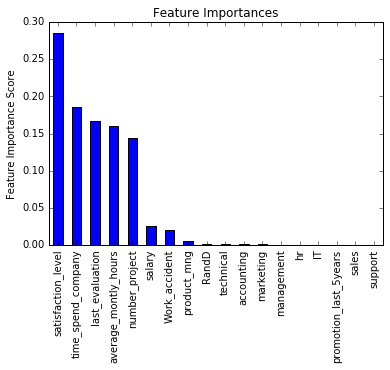

In [6]:
#baseline model (default parameters)

gbm0 = GradientBoostingClassifier(random_state=10) # default parameters
X_train,Y_train=modelfit1(gbm0,datos)